# <font color="#5fa8d3"> Yolo model


## <font color="#62b6cb"> Table of Content <a name="ToC"></a>
0. [Libraries Importation, Parameters & Funtions Definition](#id0)<br>
1. [Preparation of the data](#id1)<br>
    1.1 [Copy Images to Yolo Folder](#id11)<br>
    1.2 [Obtain the labels for YOLO](#id12)<br>
2. [Yolo Model Trainings in Sagemaker](#id2)<br>
    2.1 [Include Credentials for Sagemaker](#id21)<br>
    2.2 [Train a single model in Sagemaker](#id22)<br>
    2.3 [Hyperparameter tuning in Sagemaker](#id23)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.1 [Hyperparameters space and tuning code for Sagemaker](#id231)<br>
    &nbsp;&nbsp;&nbsp;&nbsp;2.3.2 [Select best tuning model and metrics](#id232)<br>
3. [Train with the Final Model](#id3)<br>
    3.1 [Train and Validation Datasets Union](#id31)<br>
    3.2 [Retrain the Final Model in Sagemaker](#id32)<br>
4. [Generalization Check](#id4)<br>

## <font color="#62b6cb"> 0. Libraries Importation, Parameters & Funtions Definition <a name="id0"></a>

In [22]:
# things to put in the config
'./Notebooks/data.yaml'

'./Notebooks/data.yaml'

In [1]:
import json
import os
from ultralytics import YOLO
import shutil
import yaml # for importing a yaml file
import joblib
import torch
import subprocess
from io import BytesIO
import tarfile
import pandas as pd



import boto3
import tarfile
import joblib
import sagemaker
from sagemaker.pytorch import PyTorch
from sagemaker import image_uris
from sagemaker.estimator import Estimator
from sagemaker.pytorch import PyTorch
from sagemaker.tuner import (CategoricalParameter, ContinuousParameter, IntegerParameter, HyperparameterTuner, 
                            HyperbandStrategyConfig, StrategyConfig, HyperparameterTuningJobAnalytics)

sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\teres\AppData\Local\sagemaker\sagemaker\config.yaml


In [2]:
current_directory = os.getcwd()
last_folder = os.path.basename(current_directory)
    
if last_folder != "project-danielteresa":
    while last_folder != "project-danielteresa":
        parent_directory = os.path.dirname(current_directory)
        last_folder = os.path.basename(parent_directory)

        os.chdir(parent_directory)
        print(f"Changed directory to: {parent_directory}")
else:
    print("Already in the project root directory.")

# our modules
from src.mymodule import * # for importing our functions

Changed directory to: c:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa


**Configuration Variables**

In [3]:
# Load the YAML file
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Function to set variables globally and store their names
def set_variables(config, prefix='', var_dict={}):
    for key, value in config.items():
        if isinstance(value, dict):
            set_variables(value, prefix + key + '_', var_dict)
        else:
            globals()[prefix + key] = value
            var_dict[prefix + key] = value
    return var_dict

# Set variables globally and get a dictionary of the set variables
set_vars = set_variables(config)

# Print all the variables that were set
print("Variables set from YAML file:")
for var_name, var_value in set_vars.items():
    print(f"{var_name}: {var_value}")

Variables set from YAML file:
seed: 123
color1: #62b6cb
color2: #fb8500
color3: #023047
color4: #FFB703
path_annotations: ./Data
path_train: ./Data/train/original
path_train_train: ./Data/train/train
path_train_aug: ./Data/train/train_aug
path_train_val: ./Data/train/val
path_test: ./Data/test
path_yolo: ./Data/Yoloimages/
path_models: ./Models
kaggle_train_annotations: annotations_train.json
train_annotations_name_temp: annotations_train_temp.json
train_annotations_name: annotations_train_updated.json
aug_train_annotations_name: annotations_train_updated_aug.json
val_annotations_name: annotations_val_updated.json
kaggle_test_annotations: annotations_test.json
test_annotations_name_temp: annotations_test_temp.json
test_annotations_name: annotations_test_updated.json
weights_yolo_path: Models/yolo_weights
runs_path: Models/runs
bucket_name: sagemaker-eu-west-1-project-danielteresa/
bucket_name2: sagemaker-eu-west-1-project-danielteresa


## <font color="#62b6cb"> 1. Preparation of data <a name="id1"></a>

### <font color="#62b6cb"> 1.1 Copy Images to Yolo Folder  <a name="id11"></a> 

In [4]:
# Create the folders if they don't exist
directories = [
    os.path.join(path_yolo, "train/images"),
    os.path.join(path_yolo, "train/labels"),
    os.path.join(path_yolo, "val/images"),
    os.path.join(path_yolo, "val/labels"),
    os.path.join(path_yolo, "test/images"),
    os.path.join(path_yolo, "test/labels")
]

for directory in directories:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Remove everything that exists in the folders
for directory in [    os.path.join(path_yolo, "train/images"),
                      os.path.join(path_yolo, "train/labels"),
                      os.path.join(path_yolo, "val/images"),
                      os.path.join(path_yolo, "val/labels"),
                      os.path.join(path_yolo, "test/images"),
                      os.path.join(path_yolo, "test/labels")]:
    for filename in os.listdir(directory):
        file_path = os.path.join(directory, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.unlink(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                shutil.rmtree(file_path)  # Remove the directory and its contents
        except Exception as e:
            print(f"Failed to delete {file_path}. Reason: {e}")

# Copy images from train augmented to Yolo train folder
shutil.copytree(path_train_aug, os.path.join(path_yolo, "train/images"), dirs_exist_ok=True)
shutil.copytree(path_train_val, os.path.join(path_yolo, "val/images"), dirs_exist_ok=True)
shutil.copytree(path_test, os.path.join(path_yolo, "test/images"), dirs_exist_ok=True)

print("Folders have been cleaned and files have been copied successfully.")

FileNotFoundError: [Errno 2] No such file or directory: './Data/train/train_aug'

Check the annotations and id of the coco jsons

In [ ]:
print("Check that annotation for training is correct")
print(validate_coco_dataset(os.path.join(path_annotations,aug_train_annotations_name), os.path.join(path_yolo,"train/images")))

print("Check that annotation for validation is correct")
print(validate_coco_dataset(os.path.join(path_annotations,val_annotations_name), os.path.join(path_yolo,"val/images")))

print("Check that annotation for test is correct")
print(validate_coco_dataset(os.path.join(path_annotations,test_annotations_name), os.path.join(path_yolo,"test/images")))

Check that annotation for training is correct
True
Check that annotation for validation is correct
True
Check that annotation for test is correct
True


Some of the points of the polygons are out of the range of the width and the height

In [ ]:
# Some of the points of the polygons are out of the range of the images

# train
process_coco_annotations(os.path.join(path_annotations,aug_train_annotations_name),
                          os.path.join(path_annotations,aug_train_annotations_name))

# val
process_coco_annotations(os.path.join(os.path.join(path_annotations,val_annotations_name)), 
                         os.path.join(os.path.join(path_annotations,val_annotations_name)) )

In [ ]:
with open(os.path.join(path_annotations, train_annotations_name), 'r') as f:
    coco_data = json.load(f)

# Extract image sizes
widths = []
heights = []

for image in coco_data['images']:
    widths.append(image['width'])
    heights.append(image['height'])

# Find the range of widths and heights
min_width = min(widths)
max_width = max(widths)
min_height = min(heights)
max_height = max(heights)

print(f"Width range: {min_width} to {max_width}")
print(f"Height range: {min_height} to {max_height}")

Width range: 204 to 2365
Height range: 153 to 2560


### <font color="#62b6cb"> 1.2 Obtain the labels for YOLO  <a name="id12"></a> 

Obtain the yolo txt for each images from the coco data annotations using the conver_coco from ultralytics. The annotations json to convert should be in a folder with that json in it.

In [ ]:
# Obtain the yolo labels
# train
convert_coco_to_yolo_segmentation(path_annotations, aug_train_annotations_name, path_yolo, 'train')
# val
convert_coco_to_yolo_segmentation(path_annotations, val_annotations_name, path_yolo, 'val')
# test
convert_coco_to_yolo_segmentation(path_annotations, test_annotations_name, path_yolo, 'test')

Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/train/annotations_train_updated_aug.json: 100%|██████████| 46485/46485 [00:21<00:00, 2120.37it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/train/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/val/annotations_val_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 11731.09it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/val/labels



Annotations /home/sagemaker-user/project-danielteresa/Data/Yoloimages/test/annotations_test_updated.json: 100%|██████████| 2324/2324 [00:00<00:00, 12472.27it/s]

COCO data converted successfully.
Results saved to /home/sagemaker-user/project-danielteresa/Data/Yoloimages/aux


Removed auxiliary directory ./Data/Yoloimages/aux
Yolo labels saved in ./Data/Yoloimages/test/labels



We check the nº of elememts in the folder:

In [8]:
# Define the directory path
directory_path = path_yolo +'/train/labels'

# List all files in the directory
files = os.listdir(directory_path)

# Count the number of files
file_count = len([file for file in files if os.path.isfile(os.path.join(directory_path, file))])

print(f"Number of files in '{directory_path}': {file_count}")

Number of files in './Data/Yoloimages//train/labels': 46485


## <font color="#62b6cb"> 2. Yolo Model Trainings in Sagemaker  <a name="id2"></a> 




We upload the files to S3:

In [13]:
# Define the bucket name and the folder to copy to S3
bucket_train = "sagemaker-eu-west-1-project-danielteresa/train"
local_train = "Data/Yoloimages/train"

bucket_val = "sagemaker-eu-west-1-project-danielteresa/val"
local_val = "Data/Yoloimages/val"

bucket_test = "sagemaker-eu-west-1-project-danielteresa/test"
local_test = "Data/Yoloimages/test"

# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)
upload_folder_to_s3(local_test, bucket_test)

Uploading Data/Yoloimages/test: 100%|██████████| 4649/4649 [00:26<00:00, 174.29file/s]


0

Now we upload the annotations the data.yaml file for train the model too:

In [27]:
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)

names = [class_name['name'] for class_name in coco_data["categories"]]

# Specify the paths and information

train_path = 'train_prueba/images'
path_yolo_val = 'val_prueba/images'

names_categories = [class_name['name'] for class_name in coco_data["categories"]]
nc = len(names)
file_path = './Notebooks/data.yaml'

# Create the YAML file
create_yaml_file(file_path, train_path, path_yolo_val, nc, names)

In [28]:
# Define the bucket name and the file to copy to S3
bucket_annotations = "sagemaker-eu-west-1-project-danielteresa"
file_to_upload = "./Notebooks/data.yaml"

# Upload the file to the specified S3 bucket
upload_file_to_s3(file_to_upload, bucket_annotations)

Successfully uploaded ./Notebooks/data.yaml to s3://sagemaker-eu-west-1-project-danielteresa/data.yaml


We already create the prueba images and upload:

In [29]:
# Folder Set up
train_folder = './Data/Yoloimages/train'
val_folder = './Data/Yoloimages/val'

destination_train_folder = './Data/Yoloimages/train_prueba'
destination_val_folder = './Data/Yoloimages/val_prueba'

# Seleccionar 20 imágenes de cada carpeta
select_images(train_folder, destination_train_folder, 20, 'images', 'labels', seed)
select_images(val_folder, destination_val_folder, 20, 'images', 'labels', seed)

In [30]:
# Define the bucket name and the folder to copy to S3
bucket_train = "sagemaker-eu-west-1-project-danielteresa/train_prueba"
local_train = "Data/Yoloimages/train_prueba"

bucket_val = "sagemaker-eu-west-1-project-danielteresa/val_prueba"
local_val = "Data/Yoloimages/val_prueba"


# Upload train, test and validation folders
upload_folder_to_s3(local_train, bucket_train)
upload_folder_to_s3(local_val, bucket_val)

Uploading Data/Yoloimages/val_prueba: 100%|██████████| 40/40 [00:00<00:00, 51.80file/s]


0

### <font color="#62b6cb"> 2.1. Include Credentials for Sagemaker  <a name="id21"></a> 

We define the credentials to run the trainning job

In [9]:
# ADD HERE CREDENTIALS
# Set AWS region

sts_client = boto3.client('sts')

role_arn = 'arn:aws:iam::794367255496:role/daniel.quesada10'  # Replace with your actual role ARN

assumed_role = sts_client.assume_role(
    RoleArn=role_arn,
    RoleSessionName='SageMakerSession'
)

credentials = assumed_role['Credentials']

# Use the assumed role credentials to create a new session
sagemaker_session = sagemaker.Session(
    boto3.Session(
        aws_access_key_id=credentials['AccessKeyId'],
        aws_secret_access_key=credentials['SecretAccessKey'],
        aws_session_token=credentials['SessionToken'],
    )
)

### <font color="#62b6cb"> 2.2 Train a single model in Sagemaker  <a name="id22"></a> 



We produce the train py file for running the train job:

In [5]:
%%writefile train.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    # parser.add_argument("--num_images", type=int, default=50)
    # parser.add_argument("--seed", type=int, default=123)
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument("--batch", type=int, default=5)
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

  
    # Train the YOLO model
    # yolo_model = YOLO(os.path.join(args.weights_yolo_path, "yolov8m-seg.pt"))
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

Overwriting train.py


We finally train in sagemaker:

In [6]:
image_uri = image_uris.retrieve(
    framework='pytorch',
    region='eu-west-1',
    version='1.12.1',
    py_version='py38',
    instance_type='ml.g4dn.xlarge',
    image_scope='training'
)

In [6]:
metric_definitions = [
    {"Name": "precision", "Regex": "YOLO Metric metrics/precision\\(B\\): (.*)"},
    {"Name": "recall", "Regex": "YOLO Metric metrics/recall\\(B\\): (.*)"},
    {"Name": "mAP50", "Regex": "YOLO Metric metrics/mAP50\\(B\\): (.*)"},
    {"Name": "mAP50-95", "Regex": "YOLO Metric metrics/mAP50-95\\(B\\): (.*)"},
    {"Name": "box_loss", "Regex": "YOLO Metric val/box_loss: (.*)"},
    {"Name": "cls_loss", "Regex": "YOLO Metric val/cls_loss: (.*)"},
    {"Name": "dfl_loss", "Regex": "YOLO Metric val/dfl_loss: (.*)"}
]

In [9]:
train_data_path = f's3://{bucket_name}'
output_path = f's3://{bucket_name}/output'

estimator = PyTorch(
    entry_point="train.py",
    role=role_arn,
    image_uri=image_uri, 
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'epochs': 10,
        'optimizer': 'Adam',
        'lr0': 0.01,
        'lrf': 0.01,
        'momentum': 0.937,
        'weight_decay': 0.0005
    },
    use_spot_instances=True,
    # input_mode='File',  # FastFile causes a issue with writing label cache
    debugger_hook_config=False,
    max_wait=360000+3600,
    max_run=360000,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)
estimator.fit({"train": train_data_path})

INFO:sagemaker:Creating training-job with name: pytorch-training-2024-08-03-08-36-23-343


2024-08-03 08:36:23 Starting - Starting the training job......
2024-08-03 08:37:06 Starting - Preparing the instances for training...
2024-08-03 08:37:27 Downloading - Downloading input data............................................................
2024-08-03 08:47:48 Training - Training image download completed. Training in progress..bash: cannot set terminal process group (-1): Inappropriate ioctl for device
bash: no job control in this shell
2024-08-03 08:47:49,687 sagemaker-training-toolkit INFO     Imported framework sagemaker_pytorch_container.training
2024-08-03 08:47:49,689 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2024-08-03 08:47:49,691 sagemaker-training-toolkit INFO     No Neurons detected (normal if no neurons installed)
2024-08-03 08:47:49,702 sagemaker_pytorch_container.training INFO     Block until all host DNS lookups succeed.
2024-08-03 08:47:49,705 sagemaker_pytorch_container.training INFO     Invoking user training script.



### <font color="#62b6cb"> 2.3 Hyperparameter tuning in Sagemaker  <a name="id23"></a> 





#### <font color="#62b6cb"> 2.3.1 Hyperparameters space and tuning code for Sagemaker  <a name="id231"></a> 


In [5]:
image_uri = image_uris.retrieve(
    framework='pytorch',
    region='eu-west-1',
    version='1.12.1',
    py_version='py38',
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
    # instance_type='ml.g4dn.xlarge',
    image_scope='training'
)


metric_definitions = [
    {
        "Name": "box_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "cls_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "dfl_loss", 
        "Regex": "Epoch\\s+\\d+\\/\\d+\\s+\\d+G\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)\\s+(\\d+\\.\\d+)"
    },
    {
        "Name": "mAP50", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)\\s+\\d+\\.\\d+"
    },
    {
        "Name": "mAP50-95", 
        "Regex": "all\\s+\\d+\\s+\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+\\d+\\.\\d+\\s+(\\d+\\.\\d+)"
    }
]


hyperparameter_ranges = {
    'batch': CategoricalParameter([32, 64, 128]),
    'lr0': CategoricalParameter([1e-5, 1e-4, 1e-3, 1e-2, 1e-1]),
    'lrf': CategoricalParameter([0.01, 0.1, 0.5, 1]),
    'momentum': CategoricalParameter([0.6, 0.7, 0.8, 0.9, 0.98]),
    'weight_decay': CategoricalParameter([0.0001, 0.001])
}



# hyperparameter_ranges = {
#     'epochs': IntegerParameter(100, 500, scaling_type='Auto'),
#     'batch': IntegerParameter(32, 68, scaling_type='Auto'),
#     'lr0': ContinuousParameter(1e-5, 1e-1, scaling_type='Auto'),
#     'lrf': ContinuousParameter(0.01, 1, scaling_type='Auto'),
#     'momentum': ContinuousParameter(0.6, 0.98, scaling_type='Auto'),
#     'weight_decay': ContinuousParameter(0.0, 0.001, scaling_type='Auto')
# }

cos_lr = True (Utilizes a cosine learning rate scheduler, adjusting the learning rate following a cosine curve over epochs. Helps in managing learning rate for better convergence.)
patience = 30
warmup_epochs = 10 ()
hyperparameter_ranges = {
    'epochs': IntegerParameter(100, 500, scaling_type='Auto'),
    'batch': CategoricalParameter([32, 64, 128, 256, 512]),
    'lr0': ContinuousParameter(1e-5, 1e-1, scaling_type='Auto'),
    'lrf': ContinuousParameter(0.01, 1, scaling_type='Auto'),
    'momentum': ContinuousParameter(0.6, 0.98, scaling_type='Auto'),
    'weight_decay': ContinuousParameter(0.0, 0.01, scaling_type='Auto')
}

ray -> warmup  tune.uniform(0.0, 5.0)
weigth_decay tune.uniform(0.0, 0.001)	
dropout ->  'dropout': ContinuousParameter(0.0, 0.5, scaling_type='Auto') (chatgpt)



 https://github.com/aws/amazon-sagemaker-examples/blob/main/hyperparameter_tuning/pytorch_mnist/hpo_pytorch_mnist.ipynb

In [6]:
%%writefile train_tune.py

import subprocess
import sys

# Install ultralytics
subprocess.check_call([sys.executable, "-m", "pip", "install", "ultralytics"])

import argparse
import sys
import os
import shutil
import torch

from ultralytics import YOLO


if __name__ == "__main__":
    parser = argparse.ArgumentParser()

    # Hyperparameters
    
    parser.add_argument('--epochs',type=int, help='number of training epochs')
    parser.add_argument('--patience',type=int, help='patience value')
    parser.add_argument("--batch", type=int, help='batch size')
    
    parser.add_argument('--optimizer', type=str, help='optimizer to use')
    parser.add_argument('--lr0', type=float, help='initial learning rate')
    parser.add_argument('--lrf', type=float, help='final learning rate')
    parser.add_argument('--momentum', type=float, help='momentum')
    parser.add_argument('--weight_decay', type=float, help='optimizer weight decay')

    # SageMaker specific arguments
    parser.add_argument("--model-dir", type=str, default=os.environ.get("SM_MODEL_DIR"))
    parser.add_argument("--train", type=str, default=os.environ.get("SM_CHANNEL_TRAIN"))
    parser.add_argument("--runs-path", type=str, default=os.environ.get("SM_OUTPUT_DATA_DIR"))

   
    args = parser.parse_args()

    print('---------------Debug injected environment and arguments--------------------')
    print(sys.argv)
    print(os.environ)
    print('---------------End debug----------------------')

  
    # Train the YOLO model
    # yolo_model = YOLO(os.path.join(args.weights_yolo_path, "yolov8m-seg.pt"))
    yolo_model = YOLO("yolov8m-seg.pt")
    yolo_model.train(data=os.path.join(args.train, "data.yaml"), 
                     batch=args.batch,
                     epochs=args.epochs, 
                     optimizer=args.optimizer, 
                     lr0=args.lr0, 
                     lrf=args.lrf, 
                     momentum=args.momentum,
                     weight_decay=args.weight_decay,
                     patience=args.patience,
                     task='segment',
                     project=args.runs_path)
    
    yolo_model.export()

Overwriting train_tune.py


Regarding hyperparameters we are going to do the following:

+ epochs: We will not tune this parameter as we are already including hyperparameters to tackle the overfitting. We will assume a big enough number so that the model does not underfit. Besides YOLO model selects the weights of the best performance epoch.
+ batch size: For the tuning we just try powers of 2 as it is recommended for parallel calculation efficiency. to reduce the computing time we will try medium / high batch sizes (minimum of 32), but for this we will need to use GPU instance from Sagemaker as are more appropiate for deep learning model training
+ Learning Rate: As we will be using a random seach instead of a hyperband method we will be using a list of given parameters as suggested in this [article](https://www.sciencedirect.com/science/article/pii/S2666827022000433).
+ Learning rate factor (decay the learning rate over time): Again as we will be using a random seach instead of a hyperband method we will be using a list of given parameters as it would lead to faster convergence and lower computational costs.
+ momentum: It control the exponential decay rates for the moment estimates. As mentioned in the Ultralytics [webpage](https://docs.ultralytics.com/integrations/ray-tune/#default-search-space-description) we are using the tipical range of values to tune.
+ Weight Decay: To reduce overfitting we will introduce a weight decay always but very small.
+ Optimization: we are using adam optimizacion as it is quite popular for deep learning models and it has also been recommended in this [article](https://www.sciencedirect.com/science/article/pii/S2666827022000433).
+ Early stopping: Of 30 epochs so if it is already not improving we earn some time.

In [7]:
# Estimator
train_data_path = f's3://{bucket_name}'
output_path = f's3://{bucket_name}/output'

estimator_tune = PyTorch(
    entry_point="train_tune.py",
    role=role_arn,
    image_uri=image_uri, 
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
     # instance_type='ml.p3.2xlarge', #GPU best for our problem
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'optimizer': 'Adam',
        'epochs': 100,
        'patience': 30
    },
    use_spot_instances=True,
    # input_mode='File',  # FastFile causes a issue with writing label cache
    debugger_hook_config=False,
    max_wait=360000+3600,
    max_run=360000,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)


In [ ]:
tuner = HyperparameterTuner(estimator_tune, 
                            objective_metric_name="mAP50-95", 
                            metric_definitions=metric_definitions, 
                            hyperparameter_ranges= hyperparameter_ranges, 
                            #strategy='Hyperband',
                            strategy='Random', 
                            max_jobs=2,  # Only one job needed since hyperparameters are constant
                            max_parallel_jobs=2  # Only one job needed since hyperparameters are constant
                            # strategy_config = StrategyConfig(hyperband_strategy_config=HyperbandStrategyConfig(max_resource=10, min_resource = 1))
                           )
tuner.fit({"train": train_data_path}, job_name="YOLO-tuning2")

#  ^[a-zA-Z0-9](-*[a-zA-Z0-9]){0,31}

No finished training job found associated with this estimator. Please make sure this estimator is only used for building workflow config


........................................................................................................................................................................................................................................................................................................................................................................................................................................................

##### <font color="#62b6cb"> 2.2.2 Select best tuning model and metrics  <a name="id222"></a>



Obtain the models trained by the tuner and the metrics of the model. The YOLO model selects the best weights through the epochs by defining the metric `best_metric = mAP50 * 0.9 + mAP50-95 * 0.1`. For more information on how this metric is defined and used to choose the best weights, please check this [link to the explanation](https://github.com/ultralytics/ultralytics/issues/14873).


In [10]:
name_tuning = "pytorch-training-240803-1623"


# stablish conexion with s3
s3 = boto3.client('s3')

# Retrieve training job names from the dataframe
tuner_analytics = HyperparameterTuningJobAnalytics(name_tuning)
results_df = tuner_analytics.dataframe()
training_job_names = results_df["TrainingJobName"].tolist()

In [11]:
results_df 

,batch,epochs,lr0,lrf,momentum,weight_decay,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,46.0,18.0,0.000074,0.015310,0.673789,0.000995,pytorch-training-240803-1623-004-af4c48cf,Completed,None,2024-08-03 18:34:37+01:00,2024-08-03 19:12:48+01:00,2291.0
1,66.0,22.0,0.000070,0.063731,0.837243,0.000775,pytorch-training-240803-1623-003-376c31a1,Completed,None,2024-08-03 18:09:56+01:00,2024-08-03 18:31:57+01:00,1321.0
2,38.0,16.0,0.000142,0.018377,0.619900,0.000789,pytorch-training-240803-1623-002-ebe489f6,Completed,None,2024-08-03 17:49:12+01:00,2024-08-03 18:07:42+01:00,1110.0
3,32.0,24.0,0.000731,0.315215,0.821607,0.000080,pytorch-training-240803-1623-001-e94cea16,Completed,None,2024-08-03 17:24:30+01:00,2024-08-03 17:47:45+01:00,1395.0


In [12]:
# stablish conexion with s3
s3 = boto3.client('s3')

# Retrieve training job names from the dataframe
tuner_analytics = HyperparameterTuningJobAnalytics(name_tuning)
results_df = tuner_analytics.dataframe()
training_job_names = results_df["TrainingJobName"].tolist()

# Create a dictionary to store the paths of the .tar.gz files
output_targz_dict = {
    job_name: file['Key']
    for file in s3.list_objects_v2(Bucket=bucket_name2).get("Contents", [])
    for job_name in training_job_names
    if job_name in file['Key']
}


results_df.set_index('TrainingJobName', inplace=True)

# Process each .tar.gz file and update the dataframe
for job_name, tar_gz_file in output_targz_dict.items():
    response = s3.get_object(Bucket=bucket_name2, Key=tar_gz_file)
    tar_gz_data = response['Body'].read()

    with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
        # Look for the 'train/results.csv' file inside the .tar.gz
        csv_file = tar.extractfile('train/results.csv')
        if csv_file:
            # Read the CSV file into a pandas DataFrame
            df = pd.read_csv(csv_file)
            df.columns = df.columns.str.strip()

            # Calculate the combined metric
            df['combined_metric'] = df['metrics/mAP50(M)'] * 0.9 + df['metrics/mAP50-95(M)'] * 0.1
            results_df.loc[job_name, "FinalObjectiveValue"] = df['combined_metric'].max()
            
        else:
            print(f"'train/results.csv' not found in {tar_gz_file}")


# FinalObjectiveValue = mAP50 * 0.9 + mAP50-95 * 0.1 (Segmentation)
results_df = results_df.sort_values(by='FinalObjectiveValue', ascending=False)
pd.DataFrame(results_df.iloc[0])

,pytorch-training-240803-1623-001-e94cea16
batch,32.0
epochs,24.0
lr0,0.000731
lrf,0.315215
momentum,0.821607
weight_decay,0.00008
TrainingJobStatus,Completed
FinalObjectiveValue,0.042237
TrainingStartTime,2024-08-03 17:24:30+01:00
TrainingEndTime,2024-08-03 17:47:45+01:00


Once the best model is detected, the output of this model is download it in the Models in the folder best_model_tuning_{name of the tuning joob}

In [13]:
# obtain output of the best job 
best_jobname = results_df.index[0]
targz_bestmodel = output_targz_dict[best_jobname]
path_bestmodel = os.path.join(path_models, f'best_modeltuning_{name_tuning}')

if os.path.exists(path_bestmodel):
    shutil.rmtree(path_bestmodel)
    os.makedirs(path_bestmodel)
else:
    os.makedirs(path_bestmodel)
    
# Download the .tar.gz file from S3
response = s3.get_object(Bucket=bucket_name2, Key=targz_bestmodel)
tar_gz_data = response['Body'].read()
with tarfile.open(fileobj=BytesIO(tar_gz_data), mode='r:gz') as tar:
    tar.extractall(path=path_bestmodel)

print(f"The model has been extracted to {path_bestmodel}")


C:\Users\teres\AppData\Local\Temp\ipykernel_6524\2965343839.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(path=path_bestmodel)


The model has been extracted to ./Models\best_modeltuning_pytorch-training-240803-1623


The validation metrics need to be obtained again as best.pt does not have it.

In [15]:
# Validation metrics

# try with train
path_bestmodel = os.path.join(path_models, f'best_modeltuning_{name_tuning}')
path_s3_val ='val_prueba'

# charge the best tuning mmodel
tuning_model = YOLO(os.path.join(path_bestmodel, 'train/weights/best.pt'))
# path_s3_val ='val_prueba'
path_yolo_val = os.path.join(path_yolo, path_s3_val) #creates the val folder

if os.path.exists(path_yolo_val):
    shutil.rmtree(path_yolo_val)




In [16]:
# Download the val folder from S3
s3_resource = boto3.resource('s3')
bucket = s3_resource.Bucket(bucket_name2)

for obj in bucket.objects.filter(Prefix = path_s3_val): 
        # check that the images and labels folder exits
        if not os.path.exists(os.path.join(path_yolo, os.path.dirname(obj.key))):
            os.makedirs(os.path.join(path_yolo , os.path.dirname(obj.key)))
        # save content of val folder of S3
        target = os.path.join(path_yolo, obj.key)
        bucket.download_file(obj.key, target) 
        
print(f"Number of images in validation: {len(os.listdir(f'{path_yolo_val}/images'))} \n\n")


# create a yaml for the tuning model as yolo needs the absolute dir. and sometimes we are working in different computers 

# obtain the val classes
with open(os.path.join(path_annotations,val_annotations_name), 'r') as f:
    coco_data = json.load(f)
names = [class_name['name'] for class_name in coco_data["categories"]]

Number of images in validation: 100 




In [17]:

# Specify the paths and information
nc = len(names)
path_yaml_tune = './Notebooks/data_tune.yaml'
path_yolo_val_abs =  os.path.join(os.getcwd(), f'{path_yolo_val}/images')
create_yaml_file(path_yaml_tune, None,  path_yolo_val_abs , nc, names)

# calculate the results of the metrics for val (the output will be store path_bestmodel,\val)
if os.path.exists(os.path.join(path_bestmodel, 'val')):
    shutil.rmtree(os.path.join(path_bestmodel, 'val'))

metrics = tuning_model.val(data = path_yaml_tune, project =  os.path.join(os.getcwd(), os.path.join(path_bestmodel)))

Ultralytics YOLOv8.2.71  Python-3.12.4 torch-2.3.1+cu118 CPU (12th Gen Intel Core(TM) i7-1255U)
YOLOv8m-seg summary (fused): 245 layers, 27,227,595 parameters, 0 gradients, 110.0 GFLOPs


val: Scanning C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\labels... 100 images, 0 backgrounds, 0 corrupt: 100%|██████████| 100/100 [00:00<00:00, 992.92it/s]

val: New cache created: C:\Users\teres\OneDrive\Documentos\UCD\Summer\project-danielteresa\Data\Yoloimages\val_prueba\labels.cache



                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 7/7 [00:57<00:00,  8.16s/it]


                   all        100        243     0.0205     0.0768     0.0214    0.00955      0.475    0.00684     0.0112    0.00296
              mis_lost         23         31     0.0562      0.129     0.0793     0.0227      0.267     0.0595     0.0491    0.00648
              met_tear         18         31          0          0    0.00354    0.00319          1          0          0          0
           met_scratch         41         92       0.03     0.0326     0.0134    0.00642          0          0    0.00248   0.000496
           glass_crack         17         17     0.0985      0.529     0.0947     0.0531     0.0115    0.00203      0.049     0.0197
             mis_punct         10         12          0          0          0          0          1          0          0          0
              mis_lamp         11         11          0          0          0          0          0          0          0          0
        met_dent_minor         17         22          0          0   

In [28]:
# tuning_model.metrics.save_dir
path_bestmodel

'./Models/best_modeltuning_pytorch-training-240803-1623'

In [32]:
metrics_yolo?

Signature: metrics_yolo(model, path_results_yolo, color1, color2)
Docstring:
This function provides a comprehensive analysis of YOLO model performance by generating a styled table of key metrics,
visualizing the confusion matrix, and loading the results of the training/validation process from  CSV results file generated by 
yolo.

Parameters:
- metrics: A metrics object from the YOLO model's validation or testing process, containing various performance metrics.
- path_results_yolo: The file path to the directory where YOLO training/validation results are stored, including the 'results.csv' file.
- color1: A string representing the color (in hexadecimal or named color format) to be used for certain visualizations, particularly in the styled table and confusion matrix.
- color2: A string representing an additional color to be used for visualizations if needed.
File:      ~/project-danielteresa/src/mymodule.py
Type:      function

The function for painting the metrics

,Class Name,Box Precision,Box Recall,Box F1 Score,Box AP50,Box AP50-95,Segmentation Precision,Segmentation Recall,Segmentation F1 Score,Segmentation AP50,Segmentation AP50-95
0,mis_lost,0.0562,0.1290,0.0783,0.0793,0.0227,0.2672,0.0595,0.0973,0.0491,0.0065
1,met_tear,0.0000,0.0000,0.0000,0.0035,0.0032,1.0000,0.0000,0.0000,0.0000,0.0000
2,met_scratch,0.0300,0.0326,0.0313,0.0134,0.0064,0.0000,0.0000,0.0000,0.0025,0.0005
3,glass_crack,0.0985,0.5294,0.1661,0.0947,0.0531,0.0115,0.0020,0.0035,0.0490,0.0197
4,mis_punct,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
5,mis_lamp,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
6,met_dent_minor,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
7,met_dent_medium,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000
8,met_dent_severe,0.0000,0.0000,0.0000,0.0019,0.0006,0.0000,0.0000,0.0000,0.0000,0.0000
9,all,0.0205,0.0768,0.0324,0.0214,0.0095,0.4754,0.0068,0.0135,0.0112,0.0030


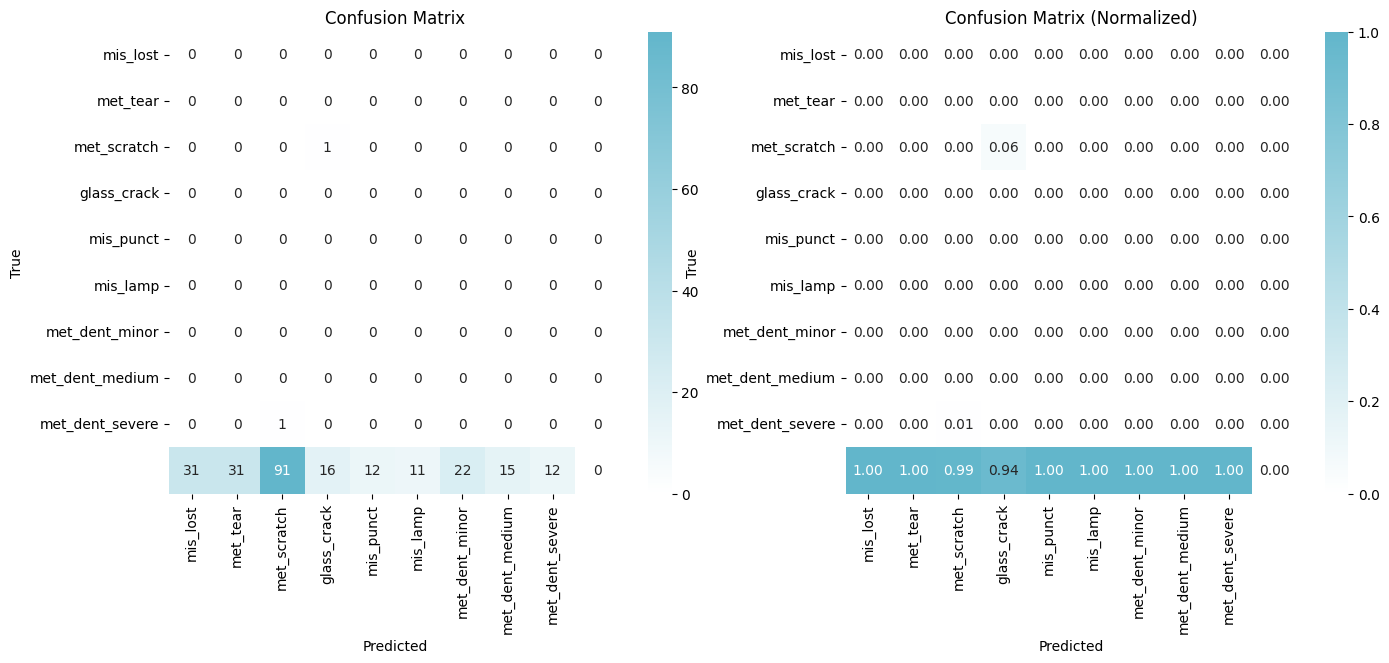

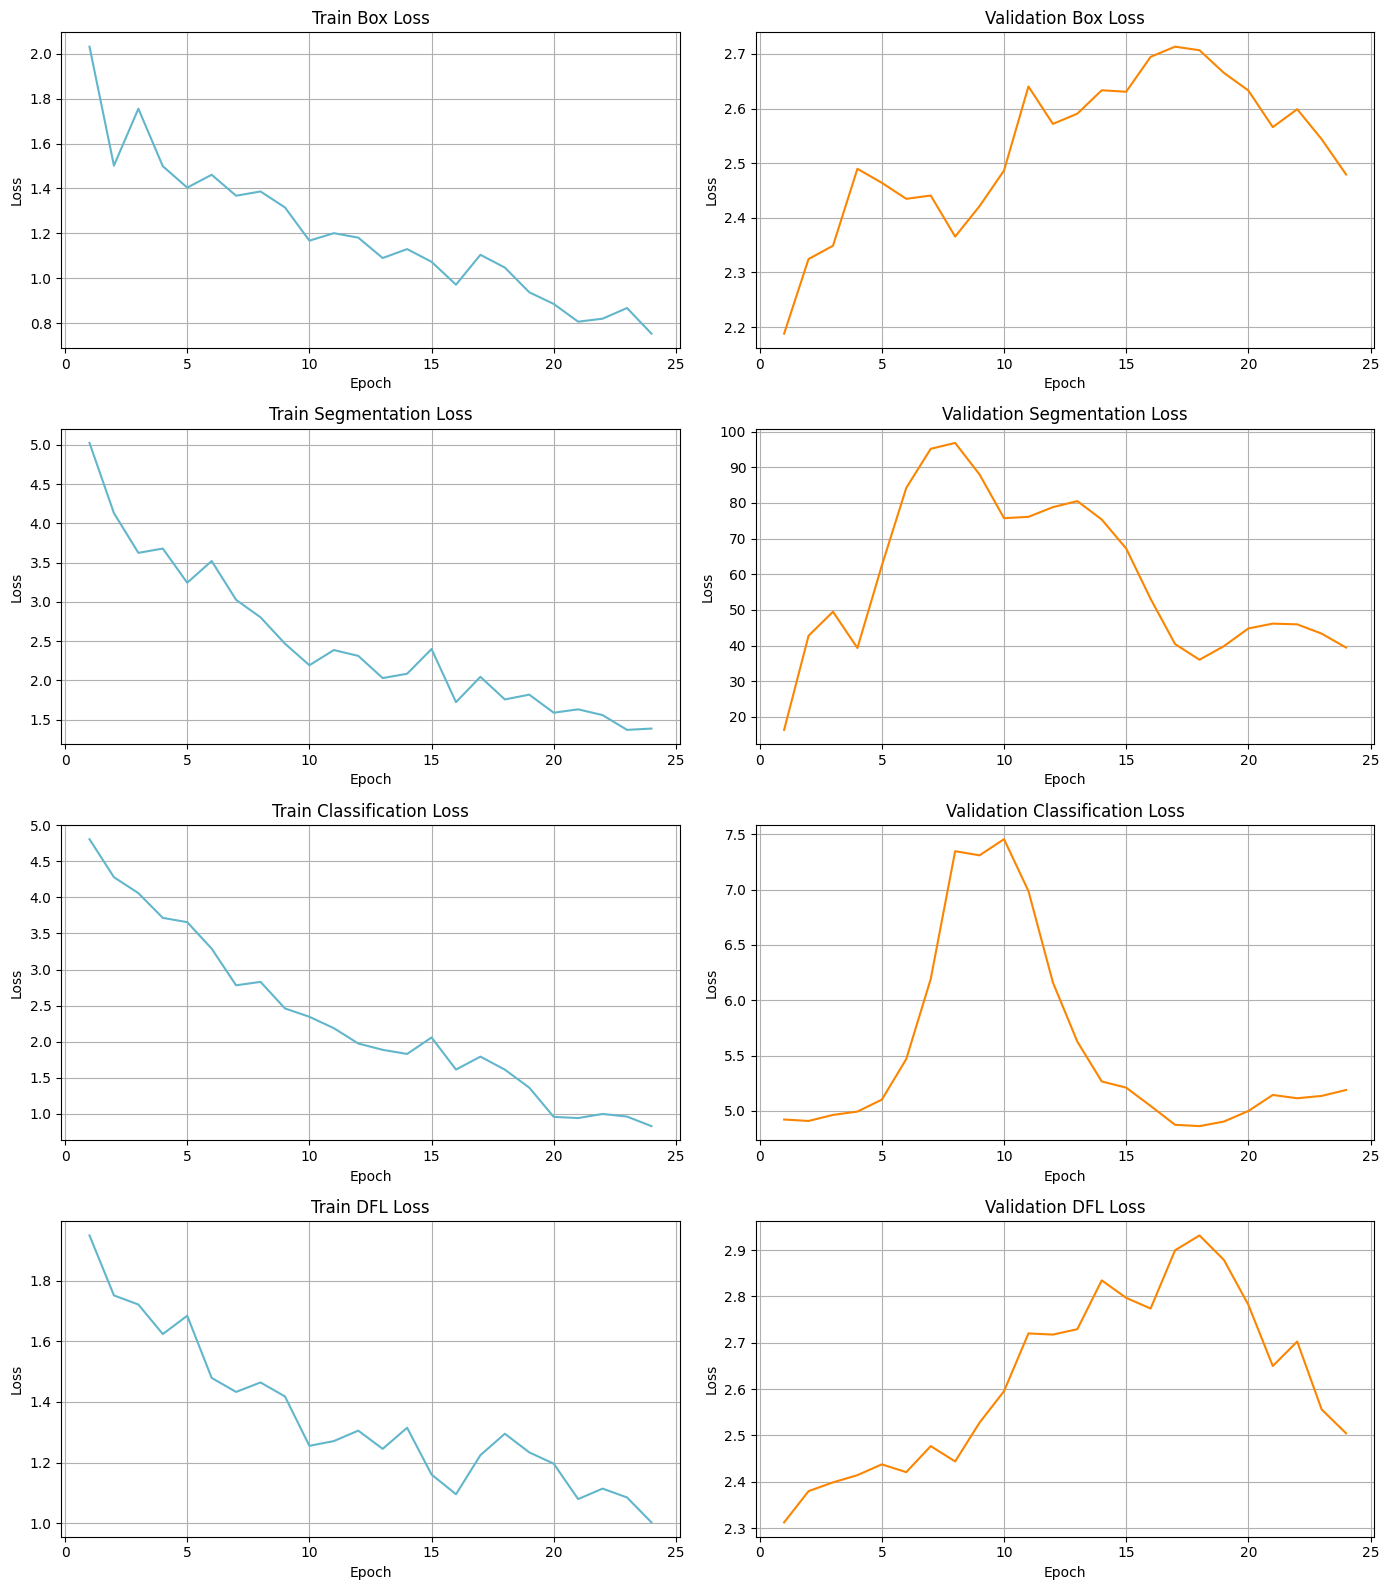

In [19]:
%matplotlib inline

# metrics_yolo(model = tuning_model, path_results_yolo = os.path.join(path_bestmodel, 'train'), color1 = color1, color2 = color2)
metrics_yolo(model = tuning_model, path_results_yolo = os.path.join(path_bestmodel, 'train'), color1 = color1, color2 = color2)
#In case of wanting delete the val folder

# if os.path.exists(path_yolo_val):
#     shutil.rmtree(path_yolo_val)

### <font color="#62b6cb"> 3. Train with the final model   <a name="id3"></a> 

### <font color="#62b6cb"> 3.1. Train and Validation Datasets Union  <a name="id31"></a> 

We create a directory of *train_final* including the validation and the train images.

In [17]:
join_train_val = False

if join_train_val:
    # path_s3_val ='val_prueba'
    path_yolo_train_final = os.path.join(path_yolo, 'train_final') #creates the train final folder

    if os.path.exists(path_yolo_train_final):
        shutil.rmtree(path_yolo_train_final)

    # Create the images and labels folders locally
    images_final_path = os.path.join(path_yolo_train_final, 'images')
    labels_final_path = os.path.join(path_yolo_train_final, 'labels')

    os.makedirs(images_final_path, exist_ok=True)
    os.makedirs(labels_final_path, exist_ok=True)

    # Download the val folder from S3
    s3_resource = boto3.resource('s3')
    bucket = s3_resource.Bucket(bucket_name2)

    # Define S3 folders
    folders = ['train_prueba/', 'val_prueba/']

    # Download images and labels from each S3 folder to the local directory
    for folder in folders:
        # Download images
        path_s3_images = os.path.join(folder, 'images/')
        for obj in bucket.objects.filter(Prefix=path_s3_images):
            if obj.key.endswith('/'):
                continue  # Skip directories
            target = os.path.join(images_final_path, os.path.basename(obj.key))
            bucket.download_file(obj.key, target)

        # Download labels
        path_s3_labels = os.path.join(folder, 'labels/')
        for obj in bucket.objects.filter(Prefix=path_s3_labels):
            if obj.key.endswith('/'):
                continue  # Skip directories
            target = os.path.join(labels_final_path, os.path.basename(obj.key))
            bucket.download_file(obj.key, target)

    print("Images and labels have been successfully downloaded to", path_yolo_train_final)

Images and labels have been successfully downloaded to ./Data/Yoloimages/train_final


In [21]:
# Define the bucket name and the folder to copy to S3
bucket_train_final = "sagemaker-eu-west-1-project-danielteresa/train_final"
local_train_final = "Data/Yoloimages/train_final"

# Upload train final
upload_folder_to_s3(local_train_final, bucket_train_final)

Uploading Data/Yoloimages/train_final: 100%|██████████| 400/400 [00:02<00:00, 133.40file/s]


0

### <font color="#62b6cb"> 3.2. Retrain the Final Model in Sagemaker  <a name="id32"></a> 

We print the hyperparameters of the best modek in validation and we create a diccionary with it:

In [ ]:
pd.DataFrame(results_df.iloc[0])

In [ ]:
# Extract the first row as a dictionary
selected_params = results_df.iloc[0].to_dict()

# Remove non-hyperparameter keys
selected_params = {k: v for k, v in selected_params.items() if k in ['batch', 'lr0', 'lrf', 'momentum', 'weight_decay']}

# Convert to appropriate types
selected_params = {k: int(v) if k == 'batch' else float(v) for k, v in selected_params.items()}

In [ ]:
estimator_train_final = PyTorch(
    entry_point="train_tune.py",
    role=role_arn,
    image_uri=image_uri, 
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    # instance_type='ml.m5.12xlarge',
     # instance_type='ml.p3.2xlarge', #GPU best for our problem
    framework_version="1.12.1",
    py_version="py38",
    sagemaker_session=sagemaker_session,
    hyperparameters={
        'optimizer': 'Adam',
        'epochs': 100,
        'patience': 30,
        'batch': selected_params['batch'], 
        'lr0': selected_params['lr0'],
        'lrf': selected_params['lrf'],
        'momentum': selected_params['momentum'],
        'weight_decay': selected_params['weight_decay']
    },
    use_spot_instances=True,
    # input_mode='File',  # FastFile causes a issue with writing label cache
    debugger_hook_config=False,
    max_wait=360000+3600,
    max_run=360000,
    output_path=output_path,
    enable_sagemaker_metrics=True,
    metric_definitions=metric_definitions,
)

# Run the training job with the selected hyperparameters
estimator_train_final.fit({"train": train_data_path}, job_name="YOLO-final")

### <font color="#62b6cb"> 4. Generalization Check   <a name="id4"></a> 

Predict and get the metric over the train dataset.

Predict and get the metric over the test dataset.